In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import pandas as pd
from category_encoders import woe
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from scipy import sparse
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.datasets import fetch_openml

In [2]:
def preprocess_and_split(X, Y, num_fold=10):
    skf = StratifiedKFold(n_splits=num_fold)

    for train_index, test_index in skf.split(X, Y):
        yield train_index, test_index

In [3]:
data = fetch_openml(name='credit-g')

/mnt/sda/boris_stanoev/PropStar/venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:303: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1.
  warn(
/mnt/sda/boris_stanoev/PropStar/venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
len(data.data.columns)

20

In [5]:
target = data.target.copy()
print(target)

0      good
1       bad
2      good
3      good
4       bad
       ... 
995    good
996    good
997    good
998     bad
999    good
Name: class, Length: 1000, dtype: category
Categories (2, object): ['bad', 'good']


In [10]:
target.value_counts(normalize=True)['good']

0.7

In [4]:
woe_cols = ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']

# ML test

In [5]:
X = data.data.copy()
y = data.target.copy()

In [6]:
vectorizer = woe.WOEEncoder(cols=woe_cols)
# vectorizer = preprocessing.OneHotEncoder(handle_unknown='ignore')
label_encoder = preprocessing.LabelEncoder()

split_gen = preprocess_and_split(X, y, num_fold=5)

for train_index, test_index in split_gen:
    X_train = X.iloc[train_index, :].copy()
    y_train = y.iloc[train_index].copy()
    X_test = X.iloc[test_index, :].copy()
    y_test = y.iloc[test_index].copy()
    train_y = label_encoder.fit_transform(y_train)
    test_y = label_encoder.transform(y_test)
    
    unique_classes = set(y_test)
    print(f"Unique classes:{unique_classes}")
    # woe_data = [woe_cols].copy()
    
    woe_train_features = vectorizer.fit_transform(X=X_train[woe_cols], y=train_y)
    woe_test_features = vectorizer.transform(X=X_test[woe_cols])
    original_train_df = X_train.copy()
    original_train_df.update(woe_train_features)
    
    original_test_df = X_test.copy()
    original_test_df.update(woe_test_features)
    
    train_x = original_train_df.copy()
    test_x = original_test_df.copy()
    print("model init")
    model = ExtraTreesClassifier(n_estimators=16,
                               random_state=0)
    model.fit(train_x, train_y)
    predictions = model.predict(test_x)
    predictions_scores = model.predict_proba(test_x)
    
    acc = accuracy_score(test_y, predictions)
    f1 = f1_score(test_y, predictions)
    print(f'ACC: {acc}')
    print(f'F1: {f1}')
    roc = roc_auc_score(test_y, predictions_scores[:,1])
    print(f'ROC AUC: {roc}')

Unique classes:{'bad', 'good'}
model init
ACC: 0.71
F1: 0.7972027972027972
ROC AUC: 0.7235714285714285
Unique classes:{'bad', 'good'}
model init
ACC: 0.705
F1: 0.7972508591065293
ROC AUC: 0.7651190476190476
Unique classes:{'bad', 'good'}
model init
ACC: 0.765
F1: 0.8459016393442622
ROC AUC: 0.7858333333333332
Unique classes:{'bad', 'good'}
model init
ACC: 0.735
F1: 0.8166089965397922
ROC AUC: 0.7555952380952381
Unique classes:{'bad', 'good'}
model init
ACC: 0.715
F1: 0.7985865724381626
ROC AUC: 0.7520238095238096


# Fit/test original columns

In [17]:
X = data.data.copy()
y = data.target.copy()

In [18]:
vectorizer = woe.WOEEncoder(cols=woe_cols)
# vectorizer = preprocessing.OneHotEncoder(handle_unknown='ignore')
label_encoder = preprocessing.LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_y = label_encoder.fit_transform(y_train)
test_y = label_encoder.transform(y_test)

unique_classes = set(y_test)
print(f"Unique classes:{unique_classes}")
# woe_data = [woe_cols].copy()

woe_train_features = vectorizer.fit_transform(X=X_train[woe_cols], y=train_y)
woe_test_features = vectorizer.transform(X=X_test[woe_cols])

original_train_df = X_train.copy()
original_train_df.update(woe_train_features)

original_test_df = X_test.copy()
original_test_df.update(woe_test_features)

train_x = original_train_df.copy()
test_x = original_test_df.copy()
model = ExtraTreesClassifier(n_estimators=16,
                           random_state=42)
model.fit(train_x, train_y)

predictions = model.predict(test_x)
predictions_scores = model.predict_proba(test_x)


acc = accuracy_score(test_y, predictions)
f1 = f1_score(test_y, predictions)
print(f'ACC: {acc}')
print(f'F1: {f1}')
roc = roc_auc_score(test_y, predictions_scores[:,1])
print(f'ROC AUC: {roc}')

Unique classes:{'bad', 'good'}
ACC: 0.7303030303030303
F1: 0.8102345415778252
ROC AUC: 0.7455575251848329


**Columns unique values**

In [19]:
for col in train_x.columns.values:
    cnt = len(train_x[col].unique())
    print(f'{col}-{cnt}')

checking_status-4
duration-29
credit_history-5
purpose-10
credit_amount-642
savings_status-5
employment-5
installment_commitment-4
personal_status-4
other_parties-3
residence_since-4
property_magnitude-4
age-53
other_payment_plans-3
housing-3
existing_credits-4
job-4
num_dependents-2
own_telephone-2
foreign_worker-2


### Feature importance based on mean decrease in impurity

In [20]:
import time
start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.006 seconds


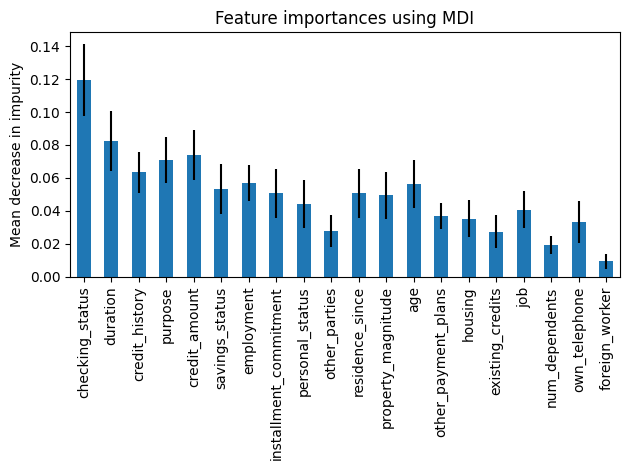

In [21]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=list(train_x.columns.values))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Fit/test added random columns

In [22]:
X = data.data.copy()
y = data.target.copy()

In [23]:
for i in range(10):
    X[f'fake_{i}'] = np.random.rand(len(X))

In [24]:
vectorizer = woe.WOEEncoder(cols=woe_cols)
# vectorizer = preprocessing.OneHotEncoder(handle_unknown='ignore')
label_encoder = preprocessing.LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_y = label_encoder.fit_transform(y_train)
test_y = label_encoder.transform(y_test)

unique_classes = set(y_test)
print(f"Unique classes:{unique_classes}")

woe_train_features = vectorizer.fit_transform(X=X_train[woe_cols], y=train_y)
woe_test_features = vectorizer.transform(X=X_test[woe_cols])

original_train_df = X_train.copy()
original_train_df.update(woe_train_features)

original_test_df = X_test.copy()
original_test_df.update(woe_test_features)

train_x = original_train_df.copy()
test_x = original_test_df.copy()
model = ExtraTreesClassifier(n_estimators=16,
                           random_state=42)
model.fit(train_x, train_y)

predictions = model.predict(test_x)
predictions_scores = model.predict_proba(test_x)


acc = accuracy_score(test_y, predictions)
f1 = f1_score(test_y, predictions)
print(f'ACC: {acc}')
print(f'F1: {f1}')
roc = roc_auc_score(test_y, predictions_scores[:,1])
print(f'ROC AUC: {roc}')

Unique classes:{'bad', 'good'}
ACC: 0.7484848484848485
F1: 0.8281573498964803
ROC AUC: 0.7646893510311731


In [25]:
train_x

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,fake_0,fake_1,fake_2,fake_3,fake_4,fake_5,fake_6,fake_7,fake_8,fake_9
703,-0.406265,30.0,0.103985,-0.320272,2503.0,-0.162643,0.420503,4.0,0.196135,0.000986,...,0.028806,0.323820,0.343882,0.110529,0.825589,0.316458,0.322522,0.226506,0.738952,0.530426
311,1.068887,24.0,-0.197129,0.047921,5511.0,-0.162643,-0.069862,4.0,0.196135,0.000986,...,0.041644,0.518806,0.709358,0.850761,0.301186,0.548941,0.653894,0.313855,0.947444,0.295744
722,-0.788349,12.0,-0.197129,-0.450325,1228.0,-0.232912,-0.069862,4.0,-0.285246,0.000986,...,0.141244,0.069729,0.411700,0.886668,0.866471,0.382528,0.838954,0.258353,0.443903,0.198955
629,1.068887,9.0,-0.197129,-0.85579,3832.0,0.453543,0.420503,1.0,0.196135,0.000986,...,0.122811,0.287777,0.067362,0.905301,0.994013,0.516422,0.642125,0.755574,0.088141,0.955939
0,-0.788349,6.0,0.825968,0.511576,1169.0,0.453543,0.420503,4.0,0.196135,0.000986,...,0.758458,0.833899,0.386907,0.289985,0.354779,0.942374,0.635014,0.196783,0.537387,0.389143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1.068887,18.0,-0.916415,-0.450325,6458.0,-0.232912,0.420503,2.0,0.196135,0.000986,...,0.007071,0.867047,0.335838,0.619400,0.890323,0.504270,0.030855,0.640255,0.046341,0.373030
270,1.068887,18.0,-0.197129,-0.450325,2662.0,0.453543,0.095186,4.0,0.196135,0.000986,...,0.505363,0.694400,0.975920,0.657586,0.899494,0.761967,0.835016,0.017286,0.180668,0.474783
860,1.068887,24.0,0.825968,0.548203,5804.0,0.902067,-0.069862,4.0,0.196135,0.000986,...,0.120393,0.863827,0.340545,0.964982,0.568328,0.450428,0.296090,0.935112,0.522994,0.764818
435,-0.406265,12.0,-0.197129,0.511576,1484.0,0.453543,-0.069862,2.0,0.006433,0.000986,...,0.815396,0.062450,0.879727,0.559358,0.999182,0.148165,0.984126,0.145623,0.265882,0.917725


### Feature importance based on mean decrease in impurity

In [26]:
import time
start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.006 seconds


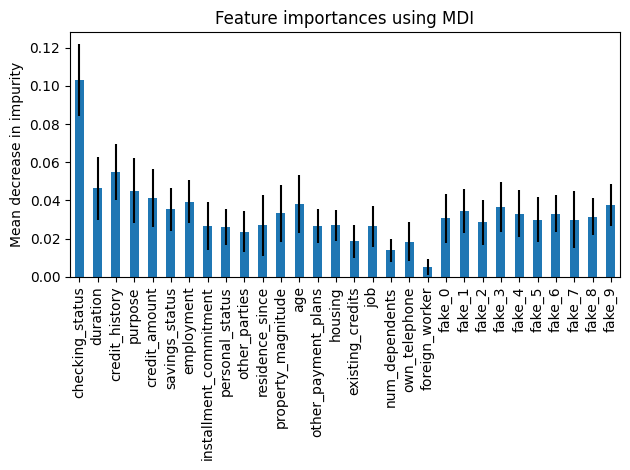

In [27]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=list(train_x.columns.values))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Boruta experiment

In [5]:
from boruta import BorutaPy

In [6]:
X = data.data.copy()
y = data.target.copy()

In [7]:
vectorizer = woe.WOEEncoder(cols=woe_cols)
# vectorizer = preprocessing.OneHotEncoder(handle_unknown='ignore')
label_encoder = preprocessing.LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_y = label_encoder.fit_transform(y_train)
test_y = label_encoder.transform(y_test)

unique_classes = set(y_test)
print(f"Unique classes:{unique_classes}")

woe_train_features = vectorizer.fit_transform(X=X_train[woe_cols], y=train_y)
woe_test_features = vectorizer.transform(X=X_test[woe_cols])

original_train_df = X_train.copy()
original_train_df.update(woe_train_features)

original_test_df = X_test.copy()
original_test_df.update(woe_test_features)

train_x = original_train_df.copy()
test_x = original_test_df.copy()
model = ExtraTreesClassifier(class_weight='balanced', max_depth=5,n_estimators=16,
                           random_state=42)
# model.fit(train_x, train_y)
feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=0)
feat_selector.fit(train_x.values, train_y)

Unique classes:{'bad', 'good'}
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	3
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	3
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	11
Tentative: 	3
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	11
Tentative: 	3
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	7
Iteration: 	13 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	7
Iteration: 	14 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	7
Iteration: 	15 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	7
Iteration: 	16 / 100
Confirmed: 	

BorutaPy(estimator=ExtraTreesClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=101,
                                        random_state=RandomState(MT19937) at 0x1EEF13BB040),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1EEF13BB040, verbose=2)

In [8]:
# # Check selected features
# print(feat_selector.support_)
# # Select the chosen features from our dataframe.
# selected = train_x[:, feat_selector.support_]
# print ("")
# print ("Selected Feature Matrix Shape")
# print (selected.shape)

In [9]:
X_selected = feat_selector.transform(train_x.values)

In [10]:
final_features = list()
indexes = np.where(feat_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(train_x.columns.values[x])
print(final_features)

['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'personal_status', 'property_magnitude', 'age', 'other_payment_plans', 'housing']


In [12]:
train_x[final_features]

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,personal_status,property_magnitude,age,other_payment_plans,housing
703,-0.406265,30.0,0.103985,-0.320272,2503.0,-0.162643,0.420503,0.196135,-0.026511,41.0,-0.162643,0.215348
311,1.068887,24.0,-0.197129,0.047921,5511.0,-0.162643,-0.069862,0.196135,-0.05443,25.0,-0.162643,0.215348
722,-0.788349,12.0,-0.197129,-0.450325,1228.0,-0.232912,-0.069862,-0.285246,0.504528,24.0,0.080806,0.215348
629,1.068887,9.0,-0.197129,-0.85579,3832.0,0.453543,0.420503,0.196135,0.504528,64.0,0.080806,0.215348
0,-0.788349,6.0,0.825968,0.511576,1169.0,0.453543,0.420503,0.196135,0.504528,67.0,0.080806,0.215348
...,...,...,...,...,...,...,...,...,...,...,...,...
106,1.068887,18.0,-0.916415,-0.450325,6458.0,-0.232912,0.420503,0.196135,-0.641381,39.0,-0.406265,0.215348
270,1.068887,18.0,-0.197129,-0.450325,2662.0,0.453543,0.095186,0.196135,-0.026511,32.0,0.080806,0.215348
860,1.068887,24.0,0.825968,0.548203,5804.0,0.902067,-0.069862,0.196135,0.504528,27.0,0.080806,0.215348
435,-0.406265,12.0,-0.197129,0.511576,1484.0,0.453543,-0.069862,0.006433,0.504528,25.0,0.080806,0.215348


In [13]:
model = ExtraTreesClassifier(class_weight='balanced', max_depth=5,n_estimators=16,
                           random_state=42)
model.fit(train_x[final_features], train_y)

ExtraTreesClassifier(class_weight='balanced', max_depth=5, n_estimators=16,
                     random_state=42)

In [14]:
predictions = model.predict(test_x[final_features])
predictions_scores = model.predict_proba(test_x[final_features])


acc = accuracy_score(test_y, predictions)
f1 = f1_score(test_y, predictions)
print(f'ACC: {acc}')
print(f'F1: {f1}')
roc = roc_auc_score(test_y, predictions_scores[:,1])
print(f'ROC AUC: {roc}')

ACC: 0.7363636363636363
F1: 0.7972027972027971
ROC AUC: 0.769207488434433


In [15]:
import time
start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.004 seconds


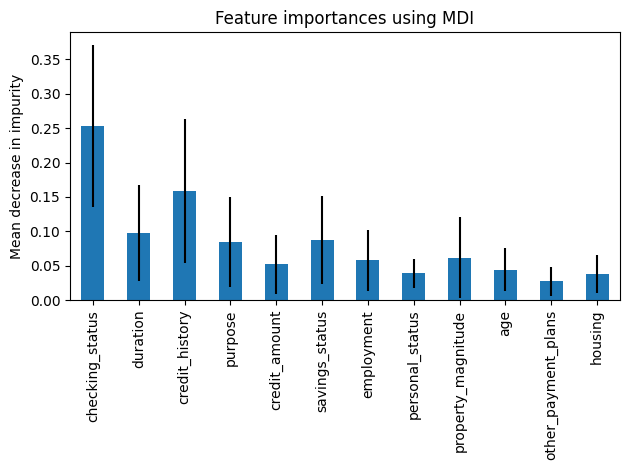

In [16]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=final_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [36]:
len(np.where(data.target == 'good')[0])

700